# 1. 사전 세팅

In [ ]:
import warnings
warnings.filterwarnings('ignore')

%cd "/content/drive/MyDrive/데이터 분석/projects/ML_portfolio/9_hvac_soh_prediction"

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 2. 문제 정의

---

    공장에는 다양한 설비가 존재한다.
    설비들에 대한 예지보전은 생산성에 매우 큰 영향을 미치기 때문에,
    센서 값에 따라 설비의 건강 상태를 예측하는 것이 매우 중요한 일이다.
    설비에서 발생하는 센서 데이터를 통해 SOH(State of Health)를 예측할 수 있는 모델을 구축할 예정이다.

## 2.1 도메인 지식

---

▸ 공조기기는?

    공조기기는 쉽게 말해 공장의 온도, 습도, 환기 상태를 일정하게 유지해주는 장비이다.
    단순히 시원하게 한다는 개념이라고 생각할 수 있지만, 생산 환경을 안정적으로 유지하는 핵심 설비로 분류된다.
    특히 반도체, 식품, 의약품 등 환경 변화에 민감한 산업에서는 라인 품질을 좌우하는 장치이기도 하다.

▸ 예지보전

    예지보전은 설비가 보내는 센서 데이터를 기반으로, 고장 가능성을 미리 예측하고 최적의 시점에 정비하는 방식이다.
    기계가 실제로 고장나기 전에 이상 징후를 감지해 정비 일정을 자동으로 잡기 때문에,
    일정 주기만 보고 정비하는 계획 정비(Preventive Maintenance)보다 훨씬 효율적이다.

▸ 삼상 전력(Three-phase Power)

    공장이나 산업용 설비에서는 대부분 삼상 전력을 사용한다.
    서로 120° 위상 차이를 가진 3개의 전력을 동시에 사용하는 방식이다.
    가정에서 쓰는 단상(1-phase)보다 훨씬 효율적이고, 고출력 모터를 안정적으로 돌릴 수 있다.

    같은 모터에서의 삼상 전력은 물리적으로 같이 움직이기 때문에 컬럼 간의 다중공선성이 발생하는 경우가 생긴다.

# 3. 데이터 간단 확인

## 3.1 데이터 명세

---
    1분 간격 설비 센서 데이터
    # 건물별, 설비별 분석은 따로 하지 않기에 DEVICE_ID와 DEVICE_BD_ID는 사용하지 않음

| Column | Description |
| :------------------ | :------------------------- |
| DEVICE_ID | 설비 번호 |
| DEVICE_BD_ID        | 설비가 설치된 건물 번호 |
| data        | 설비에서 발생하는 센서 데이터가 담겨있는 json 형태 데이터 |

---



```
data에는 다음과 같은 정보가 포함됨.

data: {
    "ITEM_NAME": "센서 이름",
    "ITEM_VALUE": "센서 값",
    "TIMESTAMP": "적재된 시간"
}
```



## 3.2 데이터 가공 명세

---

| 명세 | 내용 |
|:----|:----|
| 가공 범위 | <input type="checkbox" checked> Feature(Column) 변형<br> <input type="checkbox">기간 단위 데이터 분석 및 Big Volume 특성을 반영하기 위한 데이터 증강<br> <input type="checkbox">다양한 Table을 참조하기 위한 데이터 분할|
| 가공 상세 | <b>Feature(Column) 변형</b><br><br>- (Train data) DataFrame 내 json 타입에서 컬럼(item_name, item_value, timestamp) 추출<br>- (Test data) DataFrame 내 json 타입에서 컬럼(timestamp, label) 추출<br>- 1분당 데이터를 Summary하여 일별 데이터로 변형 |
| 가공 결과 | <b>As is</b><br><br>- row: 1509795 / column: 5 / table: 2<br><br> <b>To be</b><br><br>- row: 43137(-1466658) / column: 38(+33) / table: 1(-1)  |

## 3.3 데이터 살펴보기

In [ ]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

df = pd.read_json('Data/train/SourceData_42.json')

In [ ]:
df.info()



```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509795 entries, 0 to 1509794
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype
---  ------        --------------    -----
 0   DEVICE_ID     1509795 non-null  int64
 1   DEVICE_BD_ID  1509795 non-null  int64
 2   data          1509795 non-null  object
dtypes: int64(2), object(1)
memory usage: 34.6+ MB
```



In [ ]:
print(df['data'])



```
0          {'ITEM_NAME': '누적전력량', 'ITEM_VALUE': 79569.804...
1          {'ITEM_NAME': '선간전압평균', 'ITEM_VALUE': 396.25, ...
2          {'ITEM_NAME': '온도', 'ITEM_VALUE': 14.375, 'TIM...
3          {'ITEM_NAME': '역률평균', 'ITEM_VALUE': 0.631358, ...
4          {'ITEM_NAME': '유효전력평균', 'ITEM_VALUE': 8620.5, ...
                                 ...                        
1509790    {'ITEM_NAME': 'S상전류', 'ITEM_VALUE': 0, 'TIMEST...
1509791    {'ITEM_NAME': 'T상역률', 'ITEM_VALUE': 0, 'TIMEST...
1509792    {'ITEM_NAME': 'S상유효전력', 'ITEM_VALUE': 0, 'TIME...
1509793    {'ITEM_NAME': 'R상전류고조파', 'ITEM_VALUE': 0, 'TIM...
1509794    {'ITEM_NAME': 'S상선간전압', 'ITEM_VALUE': 395.25, ...
Name: data, Length: 1509795, dtype: object
```



In [ ]:
for idx, val in enumerate(df['data'].values):
    if idx == 20:
        break
    print(val['ITEM_NAME'], val['ITEM_VALUE'], val['TIMESTAMP'])



```
누적전력량 79569.8047 2020-10-22 00:00:40
선간전압평균 396.25 2020-10-22 00:00:40
온도 14.375 2020-10-22 00:00:40
역률평균 0.631358 2020-10-22 00:00:40
유효전력평균 8620.5 2020-10-22 00:00:40
상전압평균 228.916672 2020-10-22 00:00:40
전압고조파평균 7.421875 2020-10-22 00:00:40
주파수 59.882084 2020-10-22 00:00:40
전류고조파평균 119.88932 2020-10-22 00:00:40
무효전력평균 10588.5 2020-10-22 00:00:40
전류평균 19.979166 2020-10-22 00:00:40
전류고조파평균 120.963539 2020-10-22 00:01:40
전압고조파평균 7.5846350000000005 2020-10-22 00:01:40
누적전력량 79715.1 2020-10-22 00:01:40
선간전압평균 395.833344 2020-10-22 00:01:40
전류평균 20.052084 2020-10-22 00:01:40
유효전력평균 8639 2020-10-22 00:01:40
온도 15 2020-10-22 00:01:40
상전압평균 229 2020-10-22 00:01:40
역률평균 0.6379589999999999 2020-10-22 00:01:40
```



In [ ]:
column_cand = []

for idx, val in enumerate(df['data'].values):
    column_cand.append(val['ITEM_NAME'])

set(column_cand)



```
{'R상무효전력',
 'R상선간전압',
 'R상역률',
 'R상유효전력',
 'R상전류',
 'R상전류고조파',
 'R상전압',
 'R상전압고조파',
 'S상무효전력',
 'S상선간전압',
 'S상역률',
 'S상유효전력',
 'S상전류',
 'S상전류고조파',
 'S상전압',
 'S상전압고조파',
 'T상무효전력',
 'T상선간전압',
 'T상역률',
 'T상유효전력',
 'T상전류',
 'T상전류고조파',
 'T상전압',
 'T상전압고조파',
 '누적전력량',
 '무효전력평균',
 '상전압평균',
 '선간전압평균',
 '역률평균',
 '온도',
 '유효전력평균',
 '전류고조파평균',
 '전류평균',
 '전압고조파평균',
 '주파수'}
```



In [ ]:
df.shape



```
(1509795, 3)
```



In [ ]:
# 위 데이터를 분석에 사용하기 위해 'data' 컬럼에 있는 dict 데이터를 풀어서 사용해야 함
# ITEM_NAME: 센서명, ITEM_VALUE: 센서값, TIMESTAMP: 수집 시각
df['item_name'], df['item_value'], df['timestamp'] = zip(*df['data'].apply(lambda x: [x['ITEM_NAME'], x['ITEM_VALUE'], x['TIMESTAMP']]))

# 시계열 데이터로 재구성함
target = df.pivot(index='timestamp', columns='item_name', values='item_value').reset_index()

In [ ]:
df.head()

In [ ]:
target.head()

In [ ]:
target.shape



```
(43137, 36)
```



# 4. 문제 해결 프로세스 정의

---

▸ 문제

    공장에는 다양한 설비가 존재한다. 모든 설비는 제품을 생산하는 환경을 조성하기 위해 운영되고 있으며, 설비들의 상태에 따라 제품의 품질이 결정된다.

    1. As-Is
    현재는 1년에 한 번씩 계획 정비를 하거나, 문제가 발생할 경우(컴플레인이 들어오거나, 작업자가 문제를 인지) 해당 설비를 멈추고 조치를 취하고 있다.
    이때는 생산이 셧다운되기 때문에 손실이 발생하게 된다.

    2. To-Be
    회사에서는 각 설비의 건강 상태를 표현하여 지속적으로 문제가 발생하는 경우, 사전에 수리를 하고자 한다.

    3. Goal
    이러한 Needs에 맞춰 설비의 SOH를 예측하는 모델을 구축할 예정.
    
▸ 기대 효과

    대부분의 설비는 문제가 발생하여 동작이 멈추는 경우,
    1) 수리 비용 발생 2) 정지 시간동안 수행 가능한 생산에 대한 기대 비용이 함께 발생하기에 미연에 이상 상태를 감지해 유지보수하는 것을 통해
    1) 생산 안정성 확보 2) 다운타임(생산을 못하는 시간) 감소의 효과를 통해 전체 비용 절감 효과를 기대할 수 있다.

▸ 해결 방안

    Latency가 중요한 업무에는 데이터 구조가 고객에게 빠르게 나가야하는 구조로 짜여지기 때문에 쓸 수 없는 구조도 존재한다.
    이런 데이터를 분석할 수 있는 데이터 형태로 변환한다.

    단변량이라면 시계열 분석 혹은 Tree류 알고리즘 적용을 시도

▸ 성과 측정

    설비 SOH 예측 정확도

▸ 현업 적용

    수많은 센서 데이터가 발생할 경우, 모두를 이용해 분석하는 것보다 선택과 집중 !
    예를 들어 컬럼이 4000개 정도 생기는 센서 데이터에서는 가벼운 LightGBM 모델 등을 사용해도 잘 안 되기에
    그럴 때에는 오히려 Feature Selection에 집중 ! (한 달 내내 한 경우도 있다고...)

# 5. Data Readiness Check

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
target.head(10)

In [ ]:
target.describe().round(2)

In [ ]:
# Feature와 Target을 합치기 위해 Labeling된 데이터도 읽어오기
label_df = pd.read_json('Data/train/Combined_LabelledData_42_역률평균.json')

label_df['label'], label_df['timestamp'] = zip(*label_df['data'].apply(lambda x: [x['LABEL_NAME'], x['TIMESTAMP']]))
label_df.head()

In [ ]:
train_df = target.merge(label_df.drop_duplicates(['timestamp', 'label'])[['timestamp', 'label']], on='timestamp', how='left')
train_df.head(10)

In [ ]:
train_df.shape



```
(43137, 37)
```



In [ ]:
print(train_df.dtypes)



```
timestamp     object
R상무효전력       float64
R상선간전압       float64
R상역률         float64
R상유효전력       float64
R상전류         float64
R상전류고조파      float64
R상전압         float64
R상전압고조파      float64
S상무효전력       float64
S상선간전압       float64
S상역률         float64
S상유효전력       float64
S상전류         float64
S상전류고조파      float64
S상전압         float64
S상전압고조파      float64
T상무효전력       float64
T상선간전압       float64
T상역률         float64
T상유효전력       float64
T상전류         float64
T상전류고조파      float64
T상전압         float64
T상전압고조파      float64
누적전력량        float64
무효전력평균       float64
상전압평균        float64
선간전압평균       float64
역률평균         float64
온도           float64
유효전력평균       float64
전류고조파평균      float64
전류평균         float64
전압고조파평균      float64
주파수          float64
label         object
dtype: object
```



In [ ]:
print(train_df['label'].value_counts())



```
label
주의    25678
경고    15315
정상     2144
```



In [ ]:
# 0: 경고, 1: 정상, 2: 주의
train_df['label'] = train_df['label'].astype('category').cat.codes

In [ ]:
train_df.head(10)

# 6. Feature Engineering

In [ ]:
plt.rc('font', family='NanumBarunGothic')
train_df.hist(figsize=(28, 16))
plt.show()

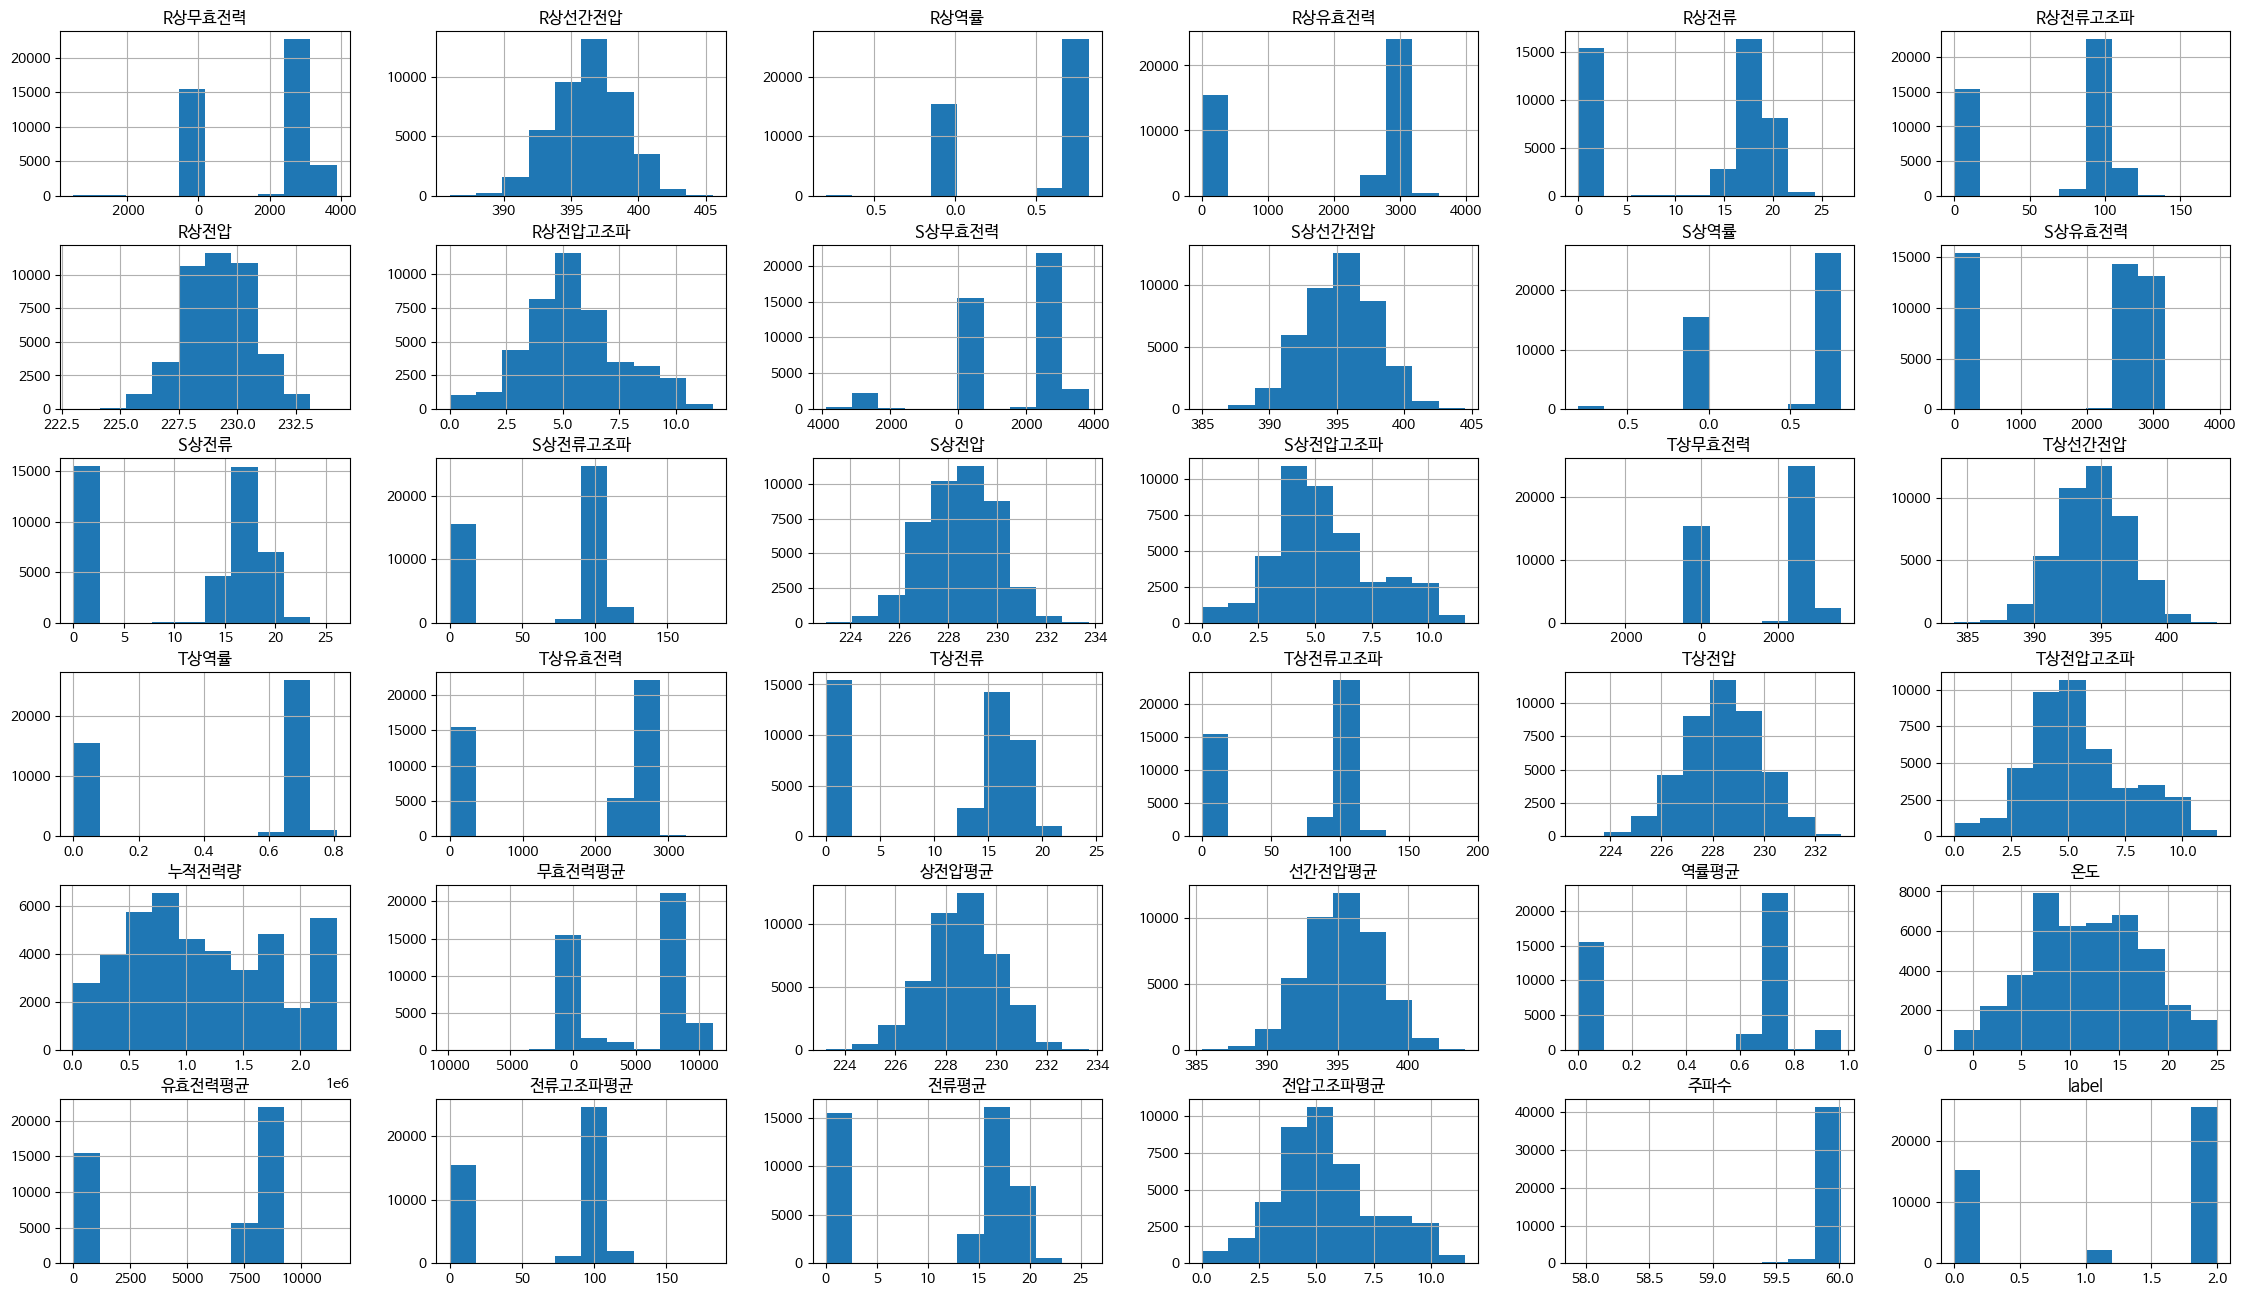

In [ ]:
plt.figure(figsize=(28, 16))

# 'timestamp' 컬럼을 제외하고 상관 관계 계산
corr_matrix = train_df.drop('timestamp', axis=1).corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, mask=mask, vmin=-1, vmax=1)

plt.show()

    RST의 삼상 전력 간의 상관 계수가 굉장히 높음을 보인다.
    다중공선성 !!
    3상 모터의 경우, RST 저력, 전류가 발생하는데, 이 센서들은 서로 상관성이 높을 수 밖에 없음

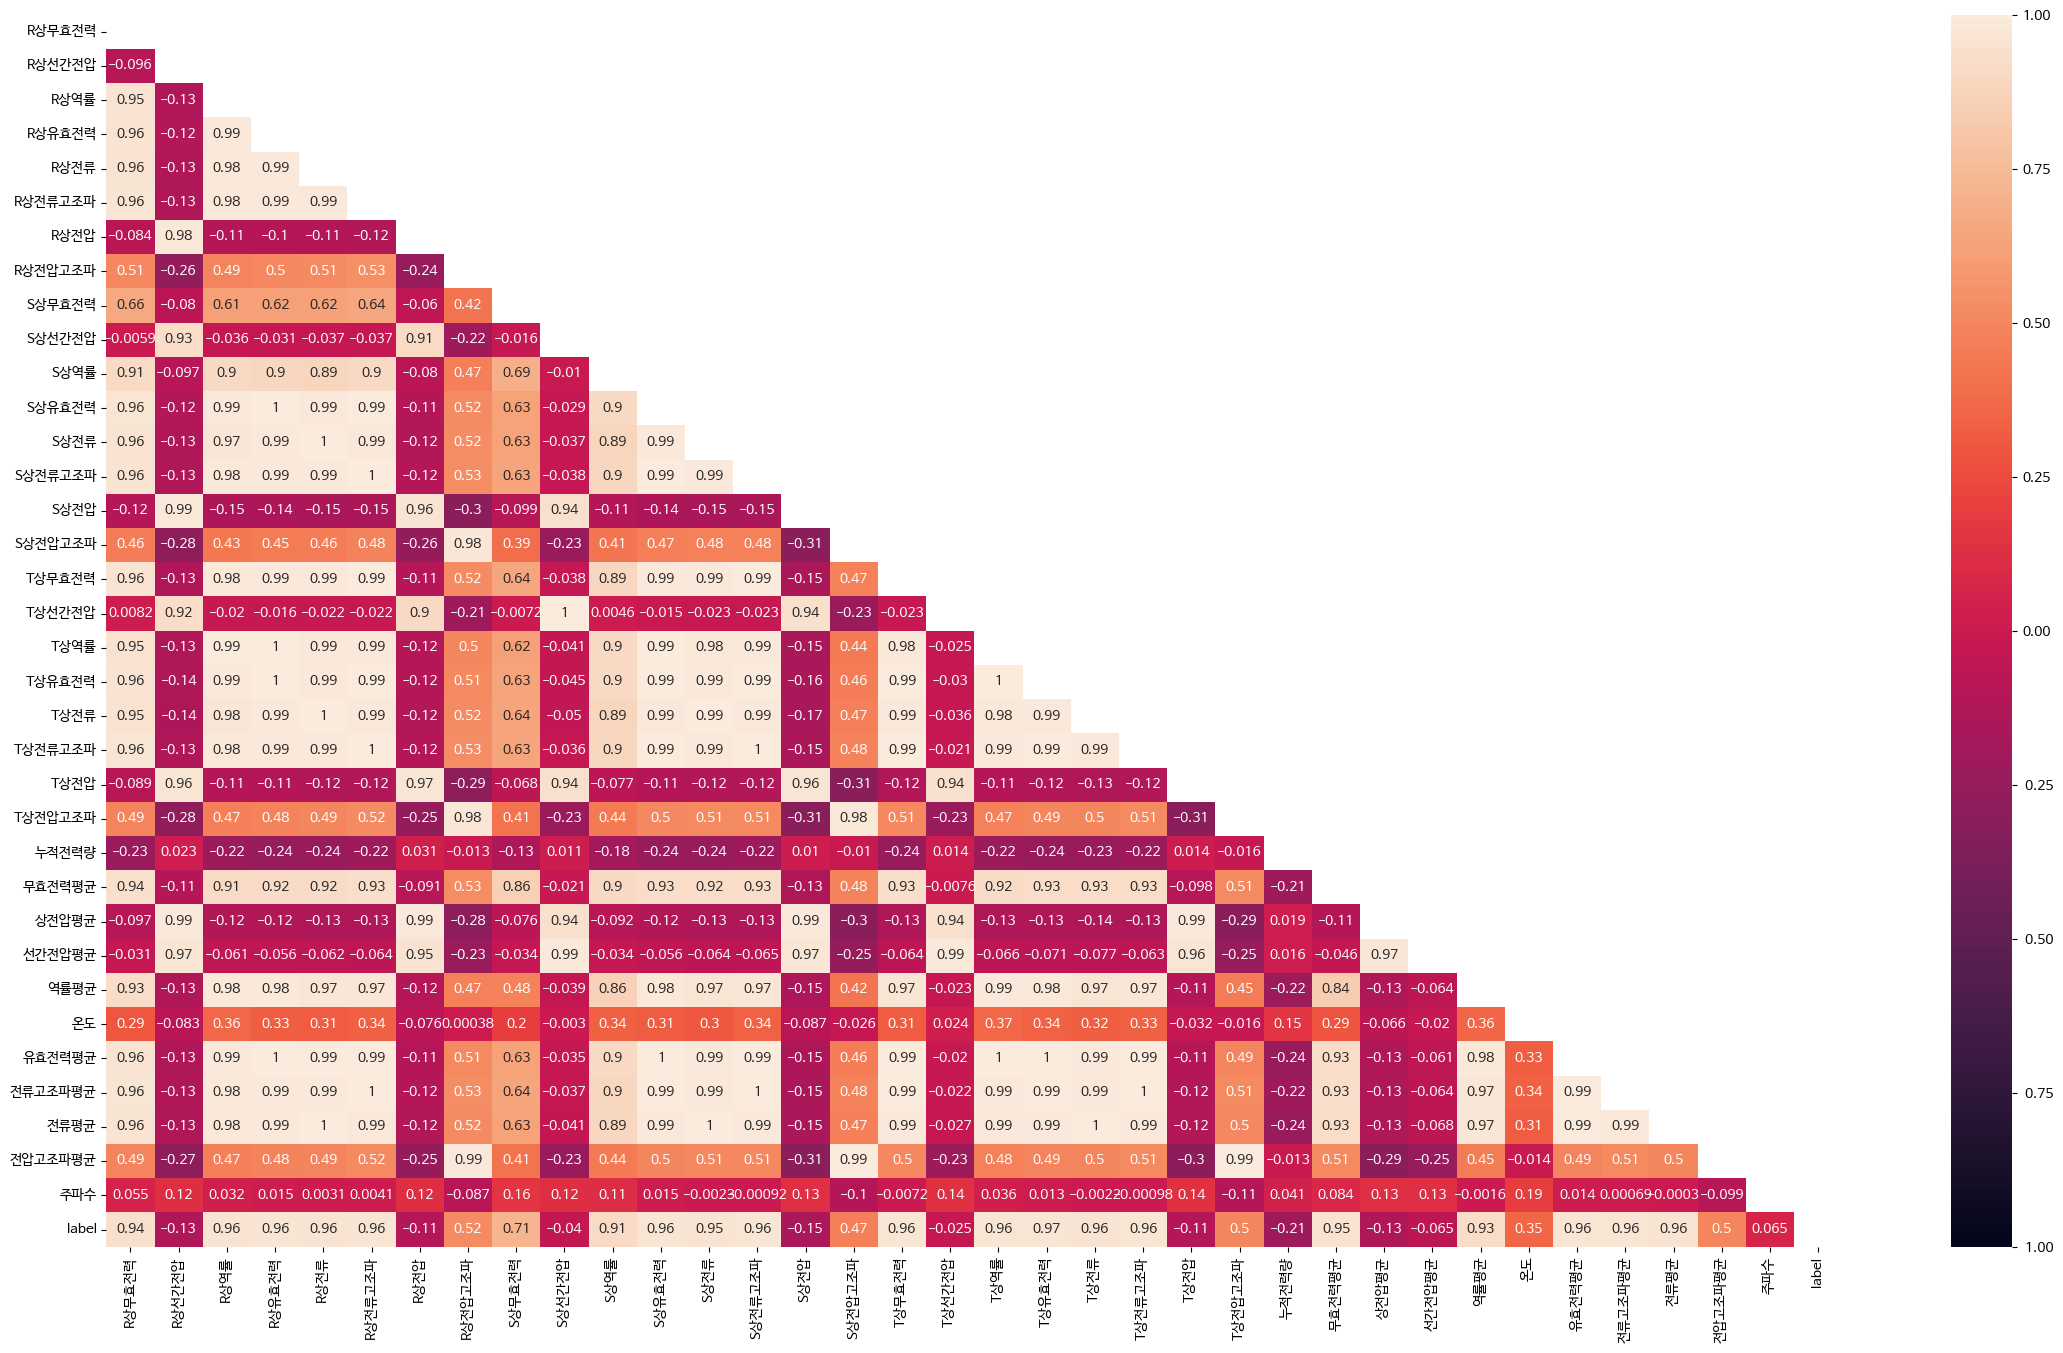

    그래서 다중공선성을 측정할 수 있는 가장 간단한 방법인 VIF(분산팽창계수)를 정의

In [ ]:
def compute_vif(df, features):
    X = df[features]
    X['intercept'] = 1

    vif = pd.DataFrame()
    vif['Variable'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable'] != 'intercept']

    return vif

In [ ]:
considered_features = train_df.columns.tolist()
considered_features.remove('timestamp')
considered_features.remove('label')

print(compute_vif(train_df, considered_features).sort_values('VIF', ascending=False).head(10))



```
    Variable    VIF
31  전류고조파평균  970969.212426
30   유효전력평균  144807.269295
13  S상전류고조파  113771.300466
21  T상전류고조파  112832.837842
5   R상전류고조파  106167.102875
3    R상유효전력   18536.626748
11   S상유효전력   16478.519766
19   T상유효전력   15590.655380
33  전압고조파평균   11920.394353
27   선간전압평균    7987.533380
```



    일반적으로 VIF 값이 5 이상이면, 다중공선성을 의심해야하는 상황인데... 거의 모든 컬럼이 다 VIF가 높다...
    곧이곧대로 쓸 수 없고, 상황에 맞게 판단해야 한다.

    오히려 다 높기 때문에 우선 모델을 구축해보고 Feature Importance 기준으로 Feature Selection을 진행하든지를 시도해야할 것 같다.

# 7. 모델링